In [1]:
from __future__ import annotations

import pathlib
import re
from datetime import datetime

import polars
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_events(logs: list[pathlib.Path]) -> polars.DataFrame:
    event_lines = []
    for log in logs:
        with open(log) as f:
            for line in f:
                if 'START' in line or 'END' in line:
                    event_lines.append(line)

    log_pattern = re.compile(
        r'\[(?P<timestamp>[\d\-:\. ]+)\] .*?\b(?P<event_type>START|END)\b (?P<task>\S+) (?P<uuid>[a-f0-9\-]{36})',
    )
    events = []
    for line in event_lines:
        matches = log_pattern.search(line)
        if matches:
            data = matches.groupdict()
            # Optionally, parse timestamp string to a datetime object
            data['timestamp'] = datetime.strptime(
                data['timestamp'],
                '%Y-%m-%d %H:%M:%S.%f',
            )
            events.append(data)

    df = polars.from_dicts(events)
    df = df.with_columns(
        [
            (
                (
                    polars.col('timestamp') - polars.col('timestamp').min()
                ).dt.total_milliseconds()
                / 1000
            ).alias('timestamp'),
        ],
    ).sort('timestamp')
    df = (
        df.group_by(['uuid', 'task'])
        .agg(
            [
                polars.col('timestamp')
                .filter(polars.col('event_type') == 'START')
                .alias('start'),
                polars.col('timestamp')
                .filter(polars.col('event_type') == 'END')
                .alias('end'),
            ],
        )
        .drop('uuid')
        .with_columns(
            [
                polars.col('start').list.first(),
                polars.col('end').list.first(),
            ],
        )
        .with_columns(polars.col('end').fill_null(polars.col('start').max()))
        .sort(['start', 'end'])
        .with_columns(
            (polars.col('end') - polars.col('start'))
            .clip(0)
            .alias('duration'),
        )
    )
    return df

In [3]:
raw = load_events(
    list(pathlib.Path('../data/mofa/29Mar25222227/').glob('*.txt')),
)

In [4]:
def partition_events(task_events, task_workers):
    all_events = {}
    for task, events in task_events.items():
        num_workers = task_workers[task]
        worker_events = {i: [] for i in range(num_workers)}
        for event in events:
            corrected = (event[0], max(0, event[1] - event[0]))
            for worker in worker_events:
                if len(worker_events[worker]) == 0:
                    worker_events[worker].append(corrected)
                    break
                # There is some asynchronicity in logging the end of a task so we assumed two tasks
                # could've run on the same worker if the are within 1 ms end time of each other.
                prior_end = (
                    worker_events[worker][-1][0] + worker_events[worker][-1][1]
                ) - 0.001
                if prior_end < event[0]:
                    worker_events[worker].append(corrected)
                    break
            else:
                print('BAD', task, event)
        all_events[task] = worker_events
    return all_events

In [5]:
task_names = [
    'generate-ligands',
    'retrain',
    'assemble-mofs',
    'validate-structures',
    'optimize-cells',
    'estimate-adsorption',
]
task_events = {
    name: raw.filter(polars.col('task') == name).select('start', 'end').rows()
    for name in task_names
}
task_workers = {
    'generate-ligands': 5,
    'retrain': 1,
    'assemble-mofs': 8,
    'validate-structures': 24,
    'optimize-cells': 4,
    'estimate-adsorption': 2,
}
# print(raw.filter(polars.col('task') == 'generate-ligands'))
partitioned = partition_events(task_events, task_workers)

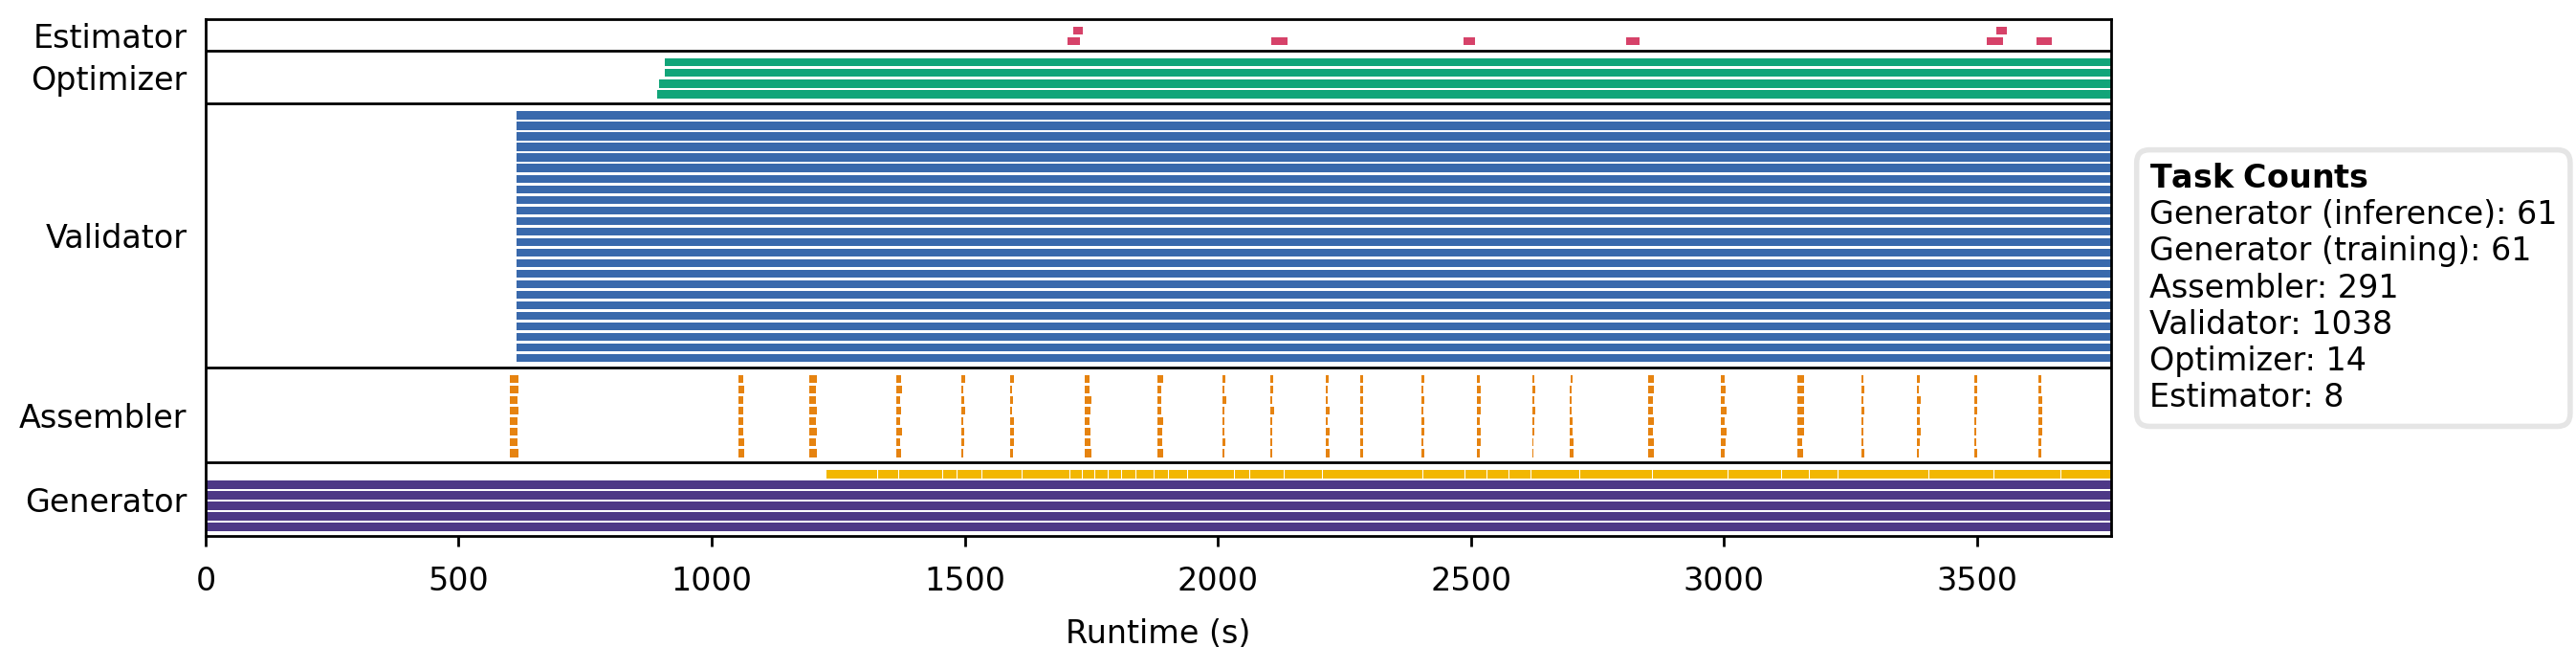

In [23]:
fig, axs = plt.subplots(1, 1)

colors = {
    'generate-ligands': '#4D3886',
    'assemble-mofs': '#E68310',
    'validate-structures': '#3969AC',
    'retrain': '#F2B701',
    'optimize-cells': '#11A579',
    'estimate-adsorption': '#D64269',
}

label_index = {}
sep_bars = []
next_index = 0
for task in partitioned:
    for worker in partitioned[task]:
        label_index[(task, worker)] = next_index
        next_index += 1
    # Add space between types
    if task in [
        'retrain',
        'assemble-mofs',
        'validate-structures',
        'optimize-cells',
    ]:
        sep_bars.append(next_index)
        next_index += 1

max_x, max_y = (raw['end'].max(), len(label_index) + len(sep_bars))

for task in partitioned:
    for worker, events in partitioned[task].items():
        index = label_index[(task, worker)]
        axs.broken_barh(
            events,
            (index, 0.75),
            facecolor=colors[task],
            label=task,
        )

for y in sep_bars:
    # axs.broken_barh([(0, max_x)], (y+0.5, 0.25), facecolor='black')
    axs.axhline(y + 0.5, xmin=0, xmax=max_x, linewidth=0.5, color='black')

axs.grid(False)
axs.set(ylim=[-0.5, max_y + 0.5], xlim=[0, max_x], xlabel='Runtime (s)')

axs.set_yticks(
    [3, 11, 28, 43, 47],
    labels=['Generator', 'Assembler', 'Validator', 'Optimizer', 'Estimator'],
)
axs.tick_params('y', length=0, width=0, which='major')

task_counts = {
    'Generator (inference)': sum(
        len(events) for events in partitioned['generate-ligands'].values()
    ),
    'Generator (training)': sum(
        len(events) for events in partitioned['retrain'].values()
    ),
    'Assembler': sum(
        len(events) for events in partitioned['assemble-mofs'].values()
    ),
    'Validator': sum(
        len(events) for events in partitioned['validate-structures'].values()
    ),
    'Optimizer': sum(
        len(events) for events in partitioned['optimize-cells'].values()
    ),
    'Estimator': sum(
        len(events) for events in partitioned['estimate-adsorption'].values()
    ),
}
structures_per_task = {
    'Generator (inference)': 512,
    'Generator (training)': 'N/A',
    'Assembler': 28,
    'Validator': 1,
    'Optimizer': 1,
    'Estimator': 1,
}
structure_counts = {
    k: v * structures_per_task[k]
    if isinstance(structures_per_task[k], int)
    else 'N/A'
    for k, v in task_counts.items()
}
# task_str = r'$\bf{Task}$ $\bf{Counts}$' + '\n' + '\n'.join(f'{k}: {structure_counts[k]} | {v}' for k, v in task_counts.items())
task_str = (
    r'$\bf{Task}$ $\bf{Counts}$'
    + '\n'
    + '\n'.join(f'{k}: {v}' for k, v in task_counts.items())
)
# axs.text(2500, 18.4, task_str, fontsize=5, alpha=1, bbox={'boxstyle': 'round', 'alpha': 0.8, 'facecolor': '#F8F8F8', 'edgecolor': '#DFDFDF', 'pad': 0.4})
axs.text(
    1.02,
    0.25,
    task_str,
    transform=axs.transAxes,
    fontsize=6,
    alpha=1,
    bbox={
        'boxstyle': 'round',
        'alpha': 0.8,
        'facecolor': 'white',
        'edgecolor': '#DFDFDF',
        'pad': 0.4,
    },
)

fig.tight_layout()
plt.draw()
fig.set_size_inches(7, 1.5)
fig.savefig('figures/mofa-gantt.pdf')